In [3]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [4]:
data_dir = "data/"

In [5]:
# Bounding Boxes Utilities

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    
    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """  
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.
    
    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
                           
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """   
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)

def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).
    
    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.
    
    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

In [6]:
# Data and Predictions Utilities

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)        
        
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [7]:
# Preprocess and Load the Dataset

def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

In [8]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [9]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [10]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [11]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

Shuffling and writing examples to /content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1.incompleteATCWKN/caltech_birds2010-train.tfrecord


Shuffling and writing examples to /content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1.incompleteATCWKN/caltech_birds2010-test.tfrecord


Dataset caltech_birds2010 downloaded and prepared to /content/drive/My Drive/TF3 C3 W1 Data/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


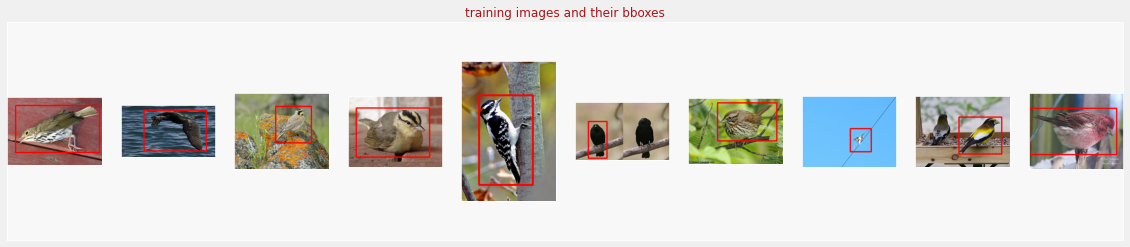

In [12]:
# Visualize the images and their bounding box labels

def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset

visualization_training_dataset = get_visualization_training_dataset()

(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


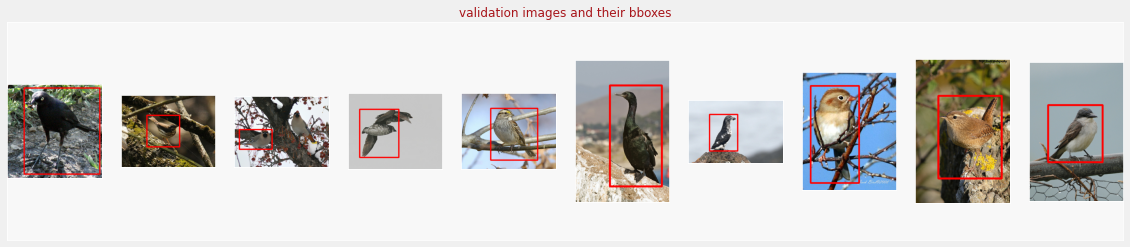

In [13]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", try_gcs=True, data_dir=data_dir)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [14]:
# Load and prepare the datasets for the model

BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

In [15]:
def feature_extractor(inputs):  
    # a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                                         include_top=False,
                                                         weights="imagenet")    

    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    
    return feature_extractor

In [16]:
def dense_layers(features):
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)    
    return x

In [17]:
def bounding_box_regression(x):
    bounding_box_regression_output = tf.keras.layers.Dense(4)(x)
    return bounding_box_regression_output

In [18]:
def final_model(inputs):
    # features
    feature_cnn = feature_extractor(inputs)
    # dense layers
    last_dense_layer = dense_layers(feature_cnn)
    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer) 

    model = tf.keras.Model(inputs = inputs, outputs = bounding_box_output)
    
    return model

In [19]:
def define_and_compile_model():
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    model = final_model(inputs)

    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
                  loss = "mse", 
                  metrics = "mse")
    return model

In [22]:
# define model
model = define_and_compile_model()

# continue training from previously saved model.
# model = tf.keras.models.load_model("birds.h5")

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052

In [23]:
# Train
EPOCHS = 50
BATCH_SIZE = 64

length_of_training_dataset = len(visualization_training_dataset)
length_of_validation_dataset = len(visualization_validation_dataset)

steps_per_epoch = length_of_training_dataset // BATCH_SIZE
if length_of_training_dataset % BATCH_SIZE > 0:
  steps_per_epoch += 1 

validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1

In [24]:
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_mse", patience=5, restore_best_weights=True)
cb_cp = tf.keras.callbacks.ModelCheckpoint("birds.h5", save_best_only=True)

class CutEarly(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("val_mse") <= 0.0050):
      self.model.stop_training=True
      print("Early stopping due to desired accuracy reached!")

cb_cut = CutEarly()

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=30, callbacks=[cb_es, cb_cp, cb_cut])

Epoch 1/30
 6/47 [==>...........................] - ETA: 16s - loss: 0.2728 - mse: 0.2728WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1340s vs `on_train_batch_end` time: 0.2216s). Check your callbacks.


47/47 [==============================] - 69s 694ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.1621 - val_mse: 0.1621


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
47/47 [==============================] - 31s 670ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.1441 - val_mse: 0.1441
Epoch 3/30
47/47 [==============================] - 32s 677ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.1160 - val_mse: 0.1160
Epoch 4/30
47/47 [==============================] - 32s 675ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.1051 - val_mse: 0.1051
Epoch 5/30
47/47 [==============================] - 31s 673ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0962 - val_mse: 0.0962
Epoch 6/30
47/47 [==============================] - 32s 675ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0826 - val_mse: 0.0826
Epoch 7/30
47/47 [==============================] - 32s 679ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0766 - val_mse: 0.0766
Epoch 8/30
47/47 [==============================] - 31s 671ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0731 - val_mse: 0.0731
Epoch 9/30
47/47 [==============================] - 31s 671ms/step - 

In [25]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 [==============================] - 12s 240ms/step - loss: 0.0251 - mse: 0.0251
Loss:  [0.02508588507771492, 0.02508588507771492]


In [26]:
!pwd

/content


In [ ]:
# Please save your model
# model.save("birds.h5")

In [ ]:
# And download it using this shortcut or from the "Files" panel to the left
# from google.colab import files

# files.download("birds.h5")

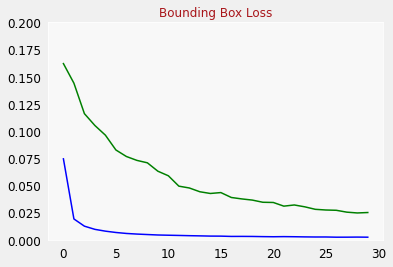

In [27]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [28]:
# performance - IoU

def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor)/(union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)

#IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 199
Number of predictions where iou < threshold(0.5): 301


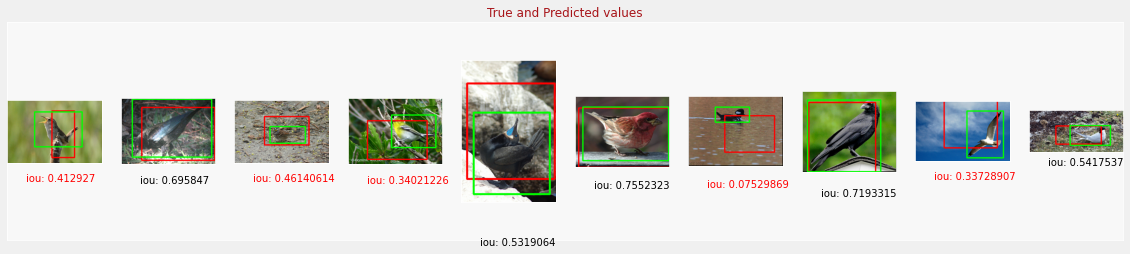

In [29]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)